In [1]:
cd totality internship


C:\Users\Gaurav\Desktop\totality internship


In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
%matplotlib inline

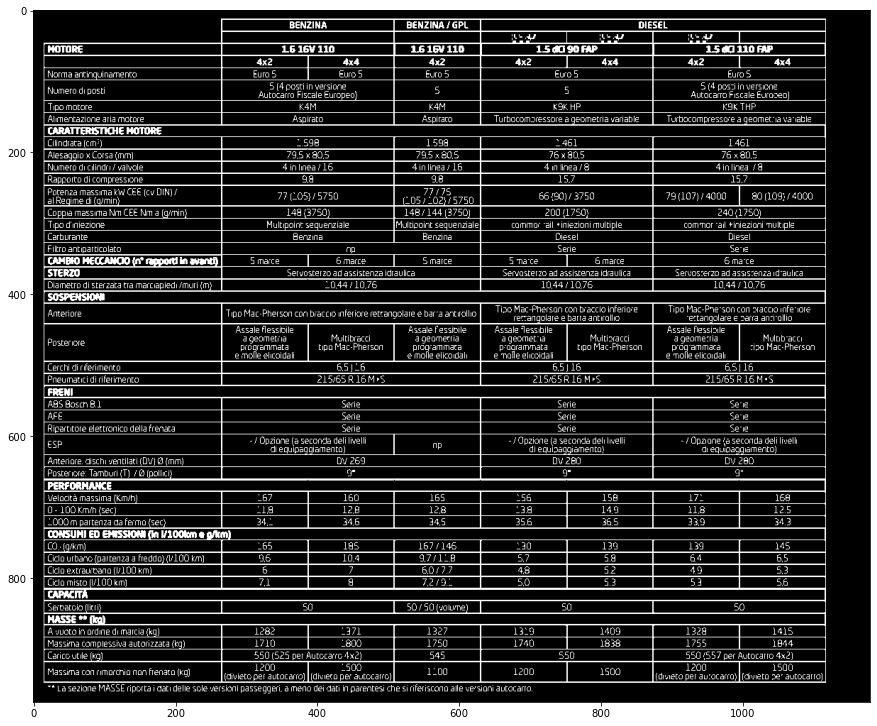

In [18]:
#read your file
file=r'table.jpg'
img = cv2.imread(file,0)
img.shape
#thresholding the image to a binary image
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
#inverting the image 
img_bin = 255-img_bin
cv2.imwrite('cv_inverted.png',img_bin)
#Plotting the image to see the output
plotting = plt.imshow(img_bin,cmap='gray')
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

In [4]:
# Length(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//100
# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

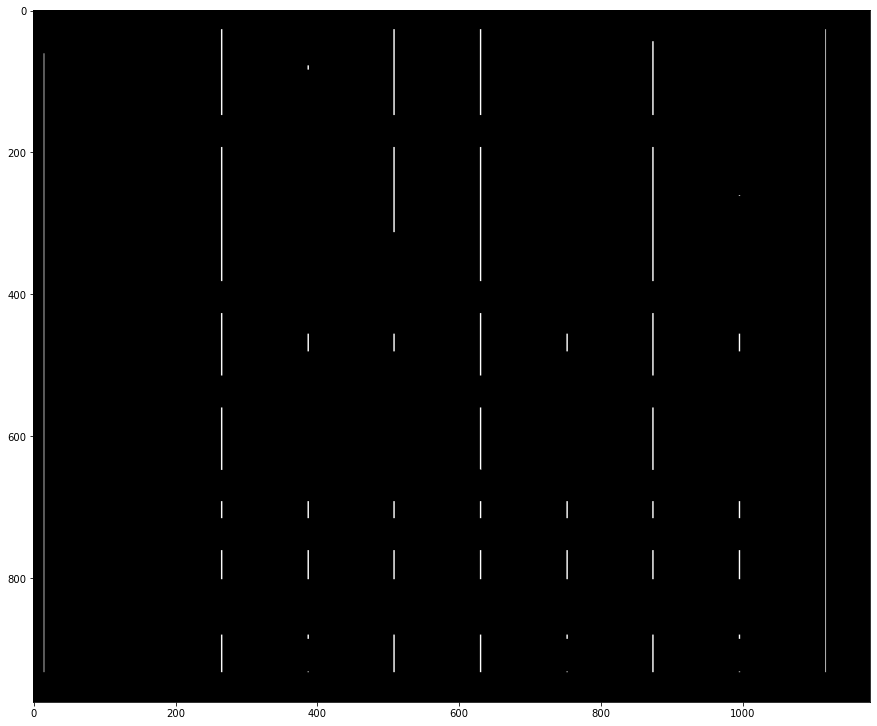

In [5]:
#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
cv2.imwrite("/Users/YOURPATH/vertical.jpg",vertical_lines)
#Plot the generated image
plotting = plt.imshow(image_1,cmap='gray')
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

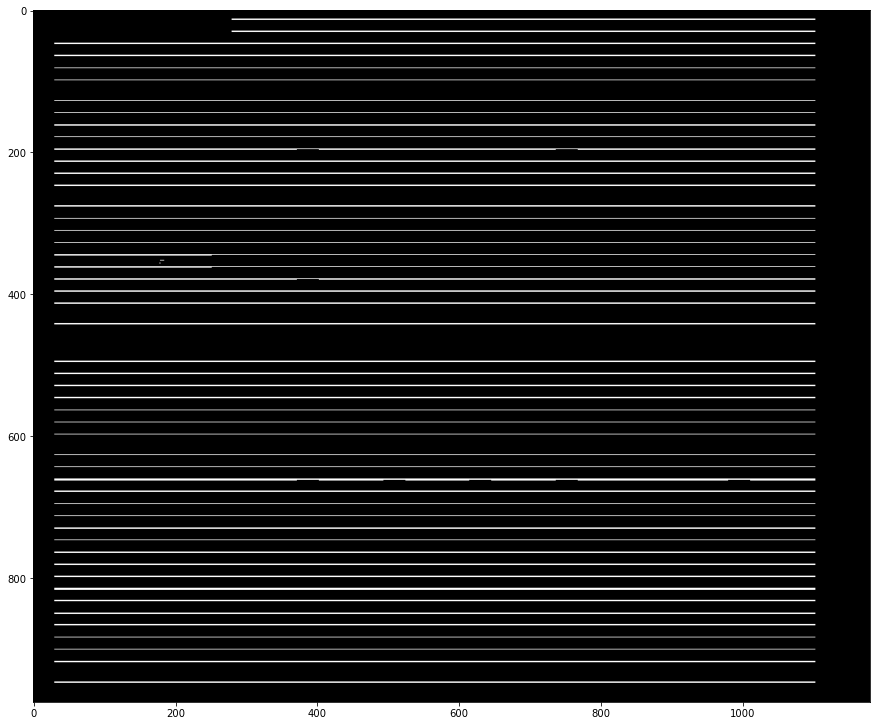

In [6]:
#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
cv2.imwrite("/Users/YOURPATH/horizontal.jpg",horizontal_lines)
#Plot the generated image
plotting = plt.imshow(image_2,cmap='gray')
plt.show()

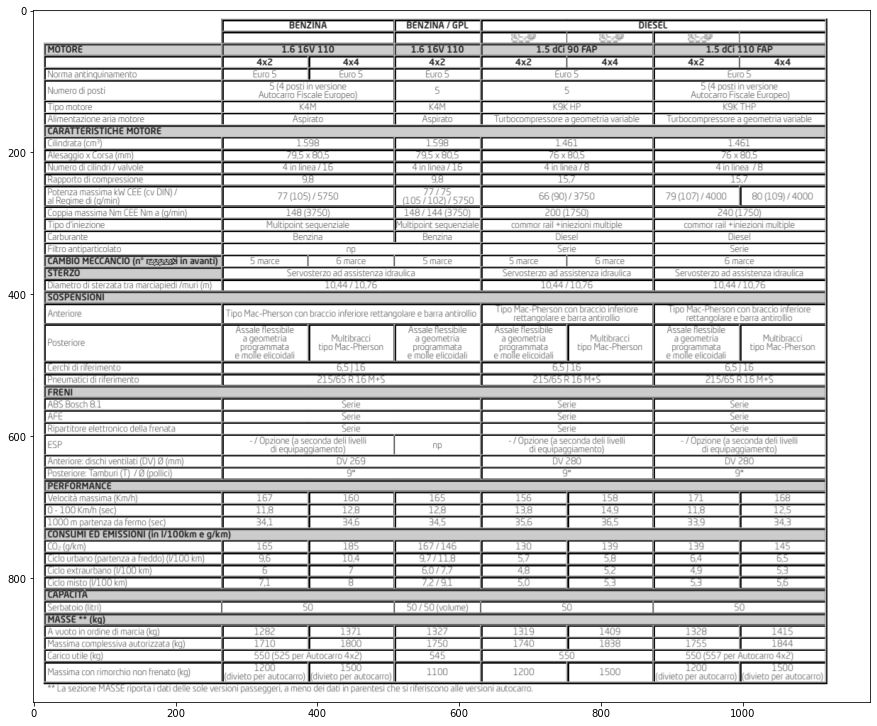

<Figure size 288x72 with 0 Axes>

In [7]:
# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite("/Users/YOURPATH/img_vh.jpg", img_vh)
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)
#Plotting the generated image
plotting = plt.imshow(bitnot,cmap='gray')
fig=plt.figure()
fig.set_figwidth(4)
fig.set_figheight(1)
plt.show()

In [8]:
# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [9]:
def sort_contours(cnts, method="left-to-right"):
        # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

In [10]:
#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
#Get mean of heights
mean = np.mean(heights)

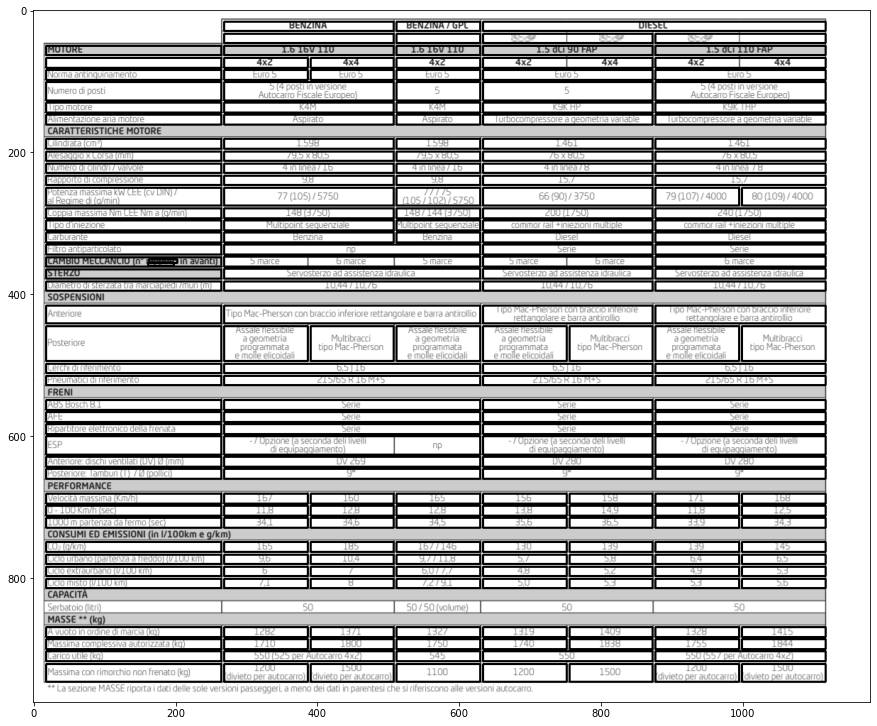

In [11]:
#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
plotting = plt.imshow(image,cmap='gray')
plt.show()


In [12]:
#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0
#Sorting the boxes to their respective row and column
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
print(column)
print(row)

[[999, 921, 118, 25], [877, 921, 118, 25], [756, 921, 117, 25], [634, 921, 118, 25], [512, 921, 118, 25], [391, 921, 117, 25], [269, 921, 118, 25], [18, 921, 247, 25]]
[[[634, 16, 483, 13], [512, 16, 118, 13], [269, 16, 239, 13]], [[877, 33, 240, 13], [634, 33, 239, 13], [512, 33, 118, 13], [269, 33, 239, 13]], [[877, 50, 240, 13], [634, 50, 239, 13], [512, 50, 118, 13], [269, 50, 239, 13], [18, 50, 247, 13]], [[877, 67, 240, 14], [634, 67, 239, 14], [512, 67, 118, 14], [391, 67, 117, 14], [269, 67, 118, 14], [18, 67, 247, 14]], [[877, 84, 240, 14], [634, 84, 239, 14], [512, 84, 118, 14], [391, 84, 117, 14], [269, 84, 118, 14], [18, 84, 247, 14]], [[877, 101, 240, 26], [634, 101, 239, 26], [512, 101, 118, 26], [269, 101, 239, 26], [18, 101, 247, 26]], [[877, 130, 240, 14], [634, 130, 239, 14], [512, 130, 118, 14], [269, 130, 239, 14], [18, 130, 247, 14]], [[877, 147, 240, 14], [634, 147, 239, 14], [512, 147, 118, 14], [269, 147, 239, 14], [18, 147, 247, 14]], [[877, 181, 240, 14], [634

In [13]:
#calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

In [14]:
#Retrieving the center of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

In [15]:
#Regarding the distance to the columns center, the boxes are arranged in respective order
finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

In [16]:
#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)

In [17]:
#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
print(dataframe)
data = dataframe.style.set_properties(align="left")
#Converting it in a excel-file
dataframe.to_csv('output.csv',index=False)

                                                    0  \
0                                                       
1                                                       
2                                           MOTORE\n   
3                                                      
4                            Norma antinquinamento\n   
5                                  Numero di posti\n   
6                                      Tipo motore\n   
7                        Alimentazione aria motore\n   
8                                 Cilindrata (cm?)\n   
9                           Alesaggio x Corsa (mm)\n   
10                    Numero di cilindri / valvole\n   
11                        Rapporto di compressione\n   
12   Potenza massima kW CEE (cv DIN) /\nal Regime ...   
13              Coppia massima Nm CEE Nm a (g/min)\n   
14                                 Tipo diniezione\n   
15                                      Carburante\n   
16                          Fil

In [59]:
pip freeze

absl-py==0.9.0
apache-beam==2.28.0
argon2-cffi==20.1.0
astor==0.8.1
astunparse==1.6.3
async-generator==1.10
attrs==20.3.0
avro-python3==1.9.2.1
backcall==0.2.0
beautifulsoup4==4.9.1
bleach==3.3.0
cachetools==4.1.1
certifi==2020.6.20
cffi==1.14.5
chardet==3.0.4
click==7.1.2
colorama==0.4.4
comtypes==1.1.7
config==0.5.0.post0
crcmod==1.7
cycler==0.10.0
Cython==0.29.21
dataclasses==0.8
decorator==4.4.2
defusedxml==0.7.1
dill==0.3.1.1
dlib==19.8.1
docker==4.4.4
docopt==0.6.2
entrypoints==0.3
face-recognition==1.3.0
face-recognition-models==0.3.0
fastavro==1.3.3
fasteners==0.16
Flask==1.1.2
flask-ngrok==0.0.25
flaskwebgui==0.1.9
flatbuffers==1.12
future==0.18.2
gast==0.3.3
getmac==0.8.2
google-api-core==1.26.1
google-api-python-client==1.12.8
google-apitools==0.5.31
google-auth==1.18.0
google-auth-httplib2==0.1.0
google-auth-oauthlib==0.4.1
google-cloud-bigquery==1.28.0
google-cloud-bigtable==1.7.0
google-cloud-build==2.0.0
google-cloud-core==1.6.0
google-cloud-datastore==1.15.3
google-clou

hdfs==2.6.0
httplib2==0.17.4
idna==2.10
importlib-metadata==1.7.0
imutils==0.5.3
ipykernel==5.5.0
ipython==7.16.1
ipython-genutils==0.2.0
ipywidgets==7.6.3
itsdangerous==1.1.0
jedi==0.18.0
Jinja2==2.11.2
joblib==0.14.1
jsonschema==3.2.0
jupyter-client==6.1.12
jupyter-core==4.7.1
jupyterlab-pygments==0.1.2
jupyterlab-widgets==1.0.0
Keras==2.4.3
Keras-Applications==1.0.8
Keras-Preprocessing==1.1.2
keras-tuner==1.0.1
keyboard==0.13.5
kiwisolver==1.2.0
kubernetes==11.0.0
libcst==0.3.17
Markdown==3.2.2
MarkupSafe==1.1.1
matplotlib==3.3.0
mistune==0.8.4
ml-metadata==0.28.0
ml-pipelines-sdk==0.28.0
mlsocket==0.1.2
mock==2.0.0
MouseInfo==0.1.3
mypy-extensions==0.4.3
nbclient==0.5.3
nbconvert==6.0.7
nbformat==5.1.2
nest-asyncio==1.5.1
notebook==6.2.0
numpy==1.19.0
oauth2client==4.1.3
oauthlib==3.1.0
opencv-python==4.3.0.36
opt-einsum==3.3.0
packaging==20.4
pandas==1.0.5
pandocfilters==1.4.3
parso==0.8.1
pbr==5.5.1
pickleshare==0.7.5
Pillow==7.2.0
prometheus-client==0.9.0
promise==2.3
prompt-too